In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import TFBertModel, BertTokenizer
import pandas as pd
import numpy as np
import re



2024-07-03 14:49:56.182064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 14:49:56.182188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 14:49:56.316171: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load and preprocess the data
d = pd.read_csv("/kaggle/input/amazon-product-review-dataset/modTrain", header=None)
data = pd.DataFrame(d)
data.columns = ['sentiment', 'text', 2]
data.drop(2, axis=1, inplace=True)
data.columns = ['sentiment', 'text']
data.drop(0, inplace=True)
data.reset_index(drop=True, inplace=True)


In [3]:
data.drop(data.index[100000:], inplace=True)

In [4]:
# Data cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = re.sub(r"\s+", " ", text)  # Remove extra spaces
    text = text.lower()  # Convert to lowercase
    return text
data['text'] = data['text'].apply(lambda x : clean_text(x))

In [5]:
# Preprocess labels
label_encoder = LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(data['text'], data['sentiment'], test_size=0.2, random_state=42)


In [6]:
train_texts.shape

(80000,)

In [7]:
data

,sentiment,text
0,1,stuning even for the nongamer this sound track...
1,1,the best soundtrack ever to anything im readin...
2,1,amazing this soundtrack is my favorite music o...
3,1,excellent soundtrack i truly like this soundtr...
4,1,remember pull your jaw off the floor after hea...
...,...,...
99995,1,good very good excelent fantastic wonderful mu...
99996,0,the real superman these are the real adventure...
99997,0,it gets one star because zero was not an optio...
99998,0,dont spend your money i think i now know more ...


In [8]:
trained_texts = list(train_texts)
valued_texts = list(val_texts)

In [9]:
# import tensorflow as tf
# from transformers import BertTokenizer
# import numpy as np

# Enable mixed precision to speed up computations
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Create a mirrored strategy for distributed training
strategy = tf.distribute.MirroredStrategy()

# Tokenization using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize in batches to manage memory
def batch_tokenize(texts, tokenizer, batch_size=5000):
    all_encodings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=128, return_tensors='tf')
        all_encodings.append(encodings)
    return all_encodings

with strategy.scope():
    train_encodings = batch_tokenize(trained_texts, tokenizer)
    val_encodings = batch_tokenize(valued_texts, tokenizer)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
val_labels

array([1, 1, 1, ..., 0, 1, 0])

In [11]:
# Create TensorFlow datasets
def create_tf_dataset(encodings, labels):
    input_ids = tf.concat([e['input_ids'] for e in encodings], axis=0)
    attention_mask = tf.concat([e['attention_mask'] for e in encodings], axis=0)
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': input_ids, 'attention_mask': attention_mask}, labels))
    return dataset

train_dataset = create_tf_dataset(train_encodings, train_labels)
val_dataset = create_tf_dataset(val_encodings, val_labels)

batch_size = 256
train_dataset = train_dataset.shuffle(len(train_texts)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


In [12]:
# Define the model
class TFSentimentAnalysisModel(tf.keras.Model):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(TFSentimentAnalysisModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=768)
        self.classifier = tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes: positive, negative, neutral

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        attn_output = self.attention(bert_output, bert_output)
        cls_output = attn_output[:, 0, :]  # Take the [CLS] token output
        logits = self.classifier(cls_output)
        return logits


In [13]:
# Distribute the model across GPUs
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = TFSentimentAnalysisModel()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [14]:
# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=20)


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.7965 - loss: 0.7950 - val_accuracy: 0.9069 - val_loss: 0.6436
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9097 - loss: 0.6404 - val_accuracy: 0.9144 - val_loss: 0.6354
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9153 - loss: 0.6349 - val_accuracy: 0.9166 - val_loss: 0.6326
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.9198 - loss: 0.6298 - val_accuracy: 0.9160 - val_loss: 0.6338
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.9214 - loss: 0.6286 - val_accuracy: 0.9201 - val_loss: 0.6291
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9247 - loss: 0.6262 - val_accuracy: 0.9220 - val_loss: 0.6277
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9251 - loss: 0.6249 - val_accuracy: 0.9181 - val_loss: 0.6314
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9285 - loss: 0.6216 - val_accu

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9430 - loss: 0.6082 - val_accuracy: 0.9249 - val_loss: 0.6251
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.9449 - loss: 0.6060 - val_accuracy: 0.9257 - val_loss: 0.6246


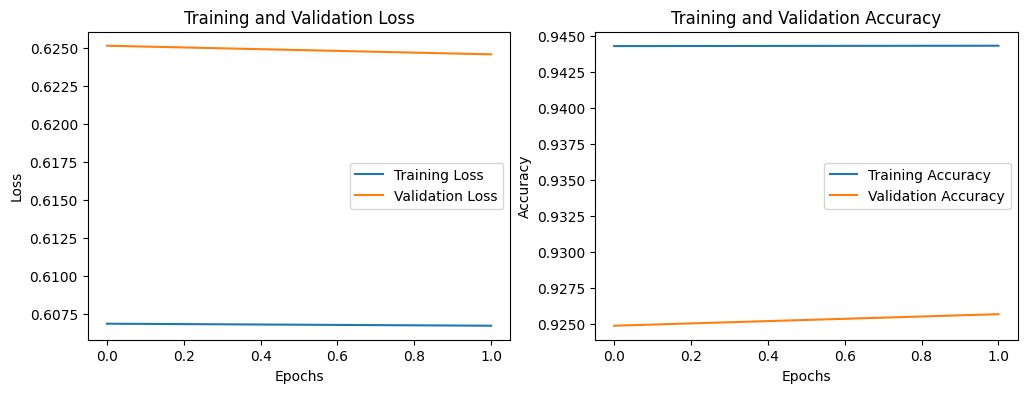

In [15]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=2)

# Plot the training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy (if applicable)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f'Validation Accuracy: {accuracy}')


79/79 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9238 - loss: 0.6259
Validation Accuracy: 0.9257000088691711
